<a href="https://colab.research.google.com/github/AN-SAFAWAT/Electrical_img_cls-FINE_TUNED/blob/main/electrical_components_Fine_tuning(VIT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine-tuning for Image Classification 🤗 Transformers**

This [notebook shows how to fine-tune a pretrained Vision model for Image Classification on an Indian Food dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## ImageFolder

This notebook leverages the [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to easily run the notebook on a custom dataset. You can either load a `Dataset` from local folders or from local/remote files, like zip or tar.

## Any model

This notebook is built to run on any image classification dataset with any vision model checkpoint from the [Model Hub](https://huggingface.co/) as long as that model has a version with a Image Classification head, such as:
* [ViT](https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification)
* [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin#transformers.SwinForImageClassification)
* [ConvNeXT](https://huggingface.co/docs/transformers/master/en/model_doc/convnext#transformers.ConvNextForImageClassification)

- in short, any model supported by [AutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification).

## Data augmentation

This notebook leverages Torchvision's [transforms](https://pytorch.org/vision/stable/transforms.html) for applying data augmentation - note that we do provide alternative notebooks which leverage other libraries, including:

* [Albumentations](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb)
* [Kornia]((https://github.com/huggingface/notebooks/blob/main/examples/image_classification_kornia.ipynb))
* [imgaug]((https://github.com/huggingface/notebooks/blob/main/examples/image_classification_imgaug.ipynb)).

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In this notebook, we'll fine-tune from the https://huggingface.co/microsoft/swin-tiny-patch4-window7-224 checkpoint, but note that there are many, many more available on the [hub](https://huggingface.co/models?other=vision).

Before we start, let's install the `datasets` and `transformers` libraries.

In [1]:
!pip install -q datasets transformers
!pip install transformers[torch] -U

import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 29.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (41

In [2]:
import sys
print(sys.executable)


/usr/bin/python3


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your dataset and model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [3]:
from huggingface_hub import notebook_login
notebook_login()



Then you need to install Git-LFS to upload your model checkpoints:

In [4]:
#%%capture
#!sudo apt -qq install git-lfs
#!git config --global credential.helper store

## Importing data into Hugging Face hub and datasets (optional)

The following is how you start with raw images and upload them into Hugging Face datasets.  For this project, if you just want to start training on the indian foods dataset, you can skip this portion of the notebook.
I started by gettig the raw image data from [Kaggle](https://www.kaggle.com/datasets/l33tc0d3r/indian-food-classification?resource=download-directory).  I put the images into my Google drive and copied it over to my Google Colab instance.  You will have to change the origin folder to your location

In [5]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Colab Notebooks/Dataset.zip" -d /tmp/foodimg


Mounted at /content/drive
Archive:  /content/drive/MyDrive/Colab Notebooks/Dataset.zip
   creating: /tmp/foodimg/Dataset/
   creating: /tmp/foodimg/Dataset/Inductor/
  inflating: /tmp/foodimg/Dataset/.DS_Store  
  inflating: /tmp/foodimg/__MACOSX/Dataset/._.DS_Store  
   creating: /tmp/foodimg/Dataset/Transformer/
   creating: /tmp/foodimg/Dataset/Capacitor/
   creating: /tmp/foodimg/Dataset/Diode/
   creating: /tmp/foodimg/Dataset/Resistor/
   creating: /tmp/foodimg/Dataset/IC/
  inflating: /tmp/foodimg/Dataset/Inductor/new_file_112.jpeg  
  inflating: /tmp/foodimg/Dataset/Inductor/new_file_93.jpeg  
  inflating: /tmp/foodimg/Dataset/Inductor/new_file_145.jpeg  
  inflating: /tmp/foodimg/Dataset/Inductor/new_file_85.jpeg  
  inflating: /tmp/foodimg/Dataset/Inductor/new_file_153.jpeg  
  inflating: /tmp/foodimg/Dataset/Inductor/new_file_104.jpeg  
  inflating: /tmp/foodimg/Dataset/Inductor/new_file_256.jpeg  
  inflating: /tmp/foodimg/Dataset/Inductor/new_file_46.jpeg  
  inflating: /t

In [6]:
import datasets

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library's [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to download our custom dataset into a DatasetDict.

In [7]:
from datasets import load_dataset
ds = load_dataset("imagefolder", data_dir="/tmp/foodimg")
#ds = load_dataset("imagefolder", data_dir="/content/drive/My Drive/Colab Notebooks/Dataset")
ds = ds['train']

Resolving data files:   0%|          | 0/4038 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

I next want to randomly created a test split for validating the model

In [8]:
data = ds.train_test_split(test_size=0.15)

In [9]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3432
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 606
    })
})

Let's now push this dataset to the Hugging face public hub.  This provides a place where this data is saved and can always be called back later.  You should change the location from `rajistics` to your account.

In [10]:
#data.push_to_hub("Safawat/electrcal_images")

This copies down the dataset from the Hugging Face public hub into your notebook.  For large datasets, look at options like streaming the dataset.

In [11]:
data = load_dataset("Safawat/electrcal_images")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3432 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/606 [00:00<?, ? examples/s]

Let's look at a sample image

In [12]:
ex = data['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x128>,
 'label': 0}

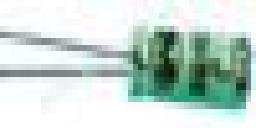

In [13]:
image = ex['image']
image

In [14]:
labels = data['train'].features['label']
labels

ClassLabel(names=['Capacitor', 'Diode', 'IC', 'Inductor', 'Resistor', 'Transformer'], id=None)

In [15]:
labels.int2str(ex['label'])

'Capacitor'

## Fine-tuning a model on an image classification task

Next, let's fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on the electrcial coponents dataset.


Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [16]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-16-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, only "train" for a training split).

In [17]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3432
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 606
    })
})

Another prepatory step is to create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [18]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

### Preprocessing the data

In [19]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Before we can feed these images to our model, we need to preprocess them.

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `torchvision.transforms` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/) etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for inference.

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing).

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((224,224)),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [20]:
#model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
from transformers import AutoImageProcessor
image_processor  = AutoImageProcessor.from_pretrained(model_name_or_path)
image_processor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer



from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [21]:
# split up training into training + validation
train_ds = data['train']
val_ds = data['test']

In [22]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Let's access an element to see that we've added a "pixel_values" feature:

In [23]:
train_ds[1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x128>,
 'label': 1,
 'pixel_values': tensor([[[ 0.4431,  0.4431,  0.4431,  ..., -0.1216, -0.1216, -0.1216],
          [ 0.4431,  0.4431,  0.4431,  ..., -0.1216, -0.1216, -0.1216],
          [ 0.4431,  0.4431,  0.4431,  ..., -0.1137, -0.1137, -0.1137],
          ...,
          [ 0.0824,  0.0824,  0.0824,  ...,  0.1529,  0.1529,  0.1529],
          [ 0.0824,  0.0824,  0.0824,  ...,  0.1529,  0.1529,  0.1529],
          [ 0.0824,  0.0824,  0.0824,  ...,  0.1529,  0.1529,  0.1529]],
 
         [[ 0.2627,  0.2627,  0.2627,  ..., -0.2863, -0.2863, -0.2863],
          [ 0.2627,  0.2627,  0.2627,  ..., -0.2863, -0.2863, -0.2863],
          [ 0.2627,  0.2627,  0.2627,  ..., -0.2863, -0.2863, -0.2863],
          ...,
          [-0.1765, -0.1765, -0.1765,  ..., -0.2000, -0.2000, -0.2000],
          [-0.1765, -0.1765, -0.1765,  ..., -0.2000, -0.2000, -0.2000],
          [-0.1765, -0.1765, -0.1765,  ..., -0.2000, -0.2000, -0.2000]]

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

NOTE: in case you're planning to fine-tune an already fine-tuned checkpoint, like [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224) (which has already been fine-tuned on ImageNet-1k), then you need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head (with 1000 output neurons) is thrown away and replaced by a new, randomly initialized classification head that includes a custom number of output neurons. You don't need to specify this argument in case the pre-trained model doesn't include a head.

In [24]:
from transformers import ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [25]:
import torch
from transformers import TrainingArguments

training_args = TrainingArguments(
  'finetuned-electrical-images',
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=10,
  #fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
  hub_strategy="end"
)#

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"nielsr/vit-finetuned-cifar10"` or `"huggingface/nielsr/vit-finetuned-cifar10"`).

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [26]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [27]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [28]:
!pip install tensorboard


Then we just need to pass all of this along with our datasets to the `Trainer`:

In [30]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

You might wonder why we pass along the `feature_extractor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [31]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.711600,0.639885,0.792079
200,0.695300,0.558875,0.808581
300,0.407800,0.494589,0.839934
400,0.585200,0.487190,0.839934
500,0.499300,0.468729,0.859736
600,0.447900,0.398560,0.884488
700,0.410100,0.438515,0.872937
800,0.283000,0.441339,0.876238
900,0.395900,0.412083,0.872937
1000,0.318000,0.439745,0.869637


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes sh

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1714139986.cee49ebfb78a.754.0:   0%|          | 0.00/57.3k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [32]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [33]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'Electrical_components(VIT)',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

events.out.tfevents.1714141556.cee49ebfb78a.754.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("Safawat/your model name")
model = AutoModelForImageClassification.from_pretrained("Safawat/your model name ")

```

## Inference

Let's say you have a new image, on which you'd like to make a prediction. Let's load a image of XYZ and see how the model does.

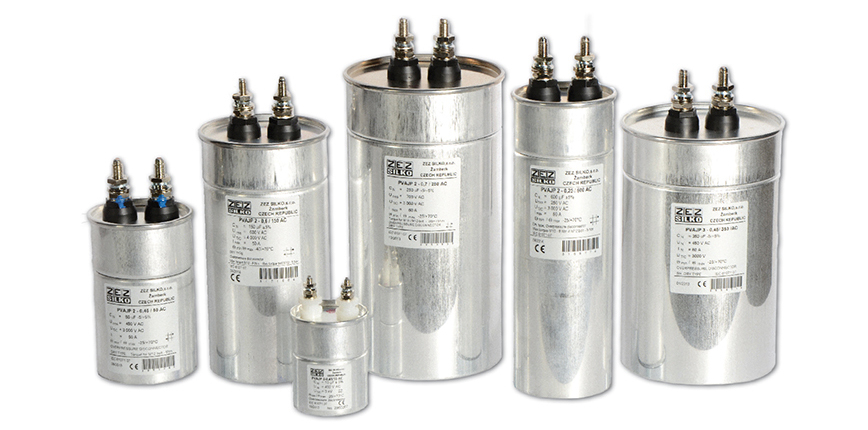

In [34]:
from PIL import Image
import requests

url = 'https://dolphincooling.com/wp-content/uploads/2023/01/AC-Capacitors.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

We'll load the feature extractor and model from the hub (here, we use the [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which will make sure the appropriate classes will be loaded automatically based on the `config.json` and `preprocessor_config.json` files of the repo on the hub):

In [35]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

repo_name = "Safawat/finetuned-electrical-images"

feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

preprocessor_config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [36]:
# prepare image for the model
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

In [37]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [38]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Looks like our model got it correct!

## Pipeline API

An alternative way to quickly perform inference with any model on the hub is by leveraging the [Pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines), which abstracts away all the steps we did manually above for us. It will perform the preprocessing, forward pass and postprocessing all in a single object.

Let's showcase this for our trained model:

In [39]:
from transformers import pipeline
pipe = pipeline("image-classification", "Safawat/finetuned-electrical-images")

In [41]:
url = 'https://dolphincooling.com/wp-content/uploads/2023/01/AC-Capacitors.jpg'
image = Image.open(requests.get(url, stream=True).raw)

pipe(image)

[{'label': 'Capacitor', 'score': 0.9802470207214355},
 {'label': 'Transformer', 'score': 0.009414060041308403},
 {'label': 'Inductor', 'score': 0.0038567373994737864},
 {'label': 'Resistor', 'score': 0.0033293352462351322},
 {'label': 'Diode', 'score': 0.0022779516875743866}]

As we can see, it does not only show the class label with the highest probability, but does return the top 5 labels, with their corresponding scores. Note that the pipelines also work with local models and feature extractors:

In [42]:
pipe = pipeline("image-classification",
                model=model,
                feature_extractor=feature_extractor)

In [43]:
pipe(image)

[{'label': 'Capacitor', 'score': 0.9802470207214355},
 {'label': 'Transformer', 'score': 0.009414060041308403},
 {'label': 'Inductor', 'score': 0.0038567373994737864},
 {'label': 'Resistor', 'score': 0.0033293352462351322},
 {'label': 'Diode', 'score': 0.0022779516875743866}]